# code tự viết

In [ ]:
def loaddataYFinance(symbol, from_date, to_date, interval):

    import pandas as pd
    import yfinance as yf

    data = yf.download(symbol, start=from_date, end=to_date, interval=interval)
    data.reset_index(inplace=True)
    data = data.rename(columns={'Date': 'Datetime'})
    data = pd.DataFrame(data, columns=['Datetime','Close'])
    # Thiết lập 'Datetime' làm chỉ mục của DataFrame
    data.set_index('Datetime', inplace=True)
    return data

In [ ]:
symbol = 'VCB.VN'
from_date = '2023-05-01'
to_date = '2023-12-09'
interval = '1d'
data_orin = loaddataYFinance(symbol, from_date, to_date, interval)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data_orin

,Close
Datetime,
2023-05-04,74936.492188
2023-05-05,76037.257812
2023-05-08,78746.828125
2023-05-09,78154.109375
2023-05-10,77900.085938
...,...
2023-12-04,86000.000000
2023-12-05,85400.000000
2023-12-06,85900.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def strategy_trading(data_orin):
  data = data_orin.copy()
  # Tính toán SMA cho giá đóng cửa
  data['SMA5'] = data['Close'].rolling(window=5).mean()
  data['SMA22'] = data['Close'].rolling(window=22).mean()

  # Tạo cột tín hiệu mua/bán
  data['BuySignal'] = (data['SMA5'] > data['SMA22']) & (data['Close'] > data['SMA5'])
  data['SellSignal'] = (data['SMA5'] < data['SMA22'])
  return data
data_mannual = strategy_trading(data_orin)

In [ ]:
import pandas as pd
import plotly.graph_objects as go

####################################################################################################
# Tạo figure
fig = go.Figure()

# Biểu đồ giá đóng cửa và SMA
fig.add_trace(go.Scatter(x=data_mannual.index, y=data_mannual['Close'], mode='lines', name='Giá Đóng Cửa', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=data_mannual.index, y=data_mannual['SMA5'], mode='lines', name='SMA5', line=dict(color='red')))
fig.add_trace(go.Scatter(x=data_mannual.index, y=data_mannual['SMA22'], mode='lines', name='SMA22', line=dict(color='blue')))

# Vẽ các điểm cho tín hiệu mua
buy_signals = data_mannual[data_mannual['BuySignal']]
fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['Close'], mode='markers', name='Buy Signal', marker=dict(symbol='triangle-up', size=10, color='green')))

# Vẽ các điểm cho tín hiệu bán
sell_signals = data_mannual[data_mannual['SellSignal']]
fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['Close'], mode='markers', name='Sell Signal', marker=dict(symbol='triangle-down', size=10, color='red')))

fig.update_layout(title='Giá Đóng Cửa và SMA', yaxis_title='Giá', xaxis_rangeslider_visible=False, height=500)

# Hiển thị biểu đồ
fig.show()


In [ ]:
data_mannual.to_csv('data.csv')

BACKTEST

In [ ]:
def backtest(data, initial_capital, shares_per_signal):
    import pandas as pd
    import matplotlib.pyplot as plt
    import plotly.graph_objects as go
    import plotly.express as px

    capital = initial_capital
    shares_held = 0

        # Xác định vị thế mua/ bán
    data['Position_Buy'] = data['BuySignal'].shift()
    data['Position_Sell'] = data['SellSignal'].shift()

    data['Trade_Action'] = ''
    data['Capital'] = capital
    data['Shares_Held'] = shares_held

        # Lặp qua mỗi hàng trong DataFrame
    for index, row in data.iterrows():
            # Nếu có tín hiệu mua và có đủ vốn để mua
        # if row['Position_Buy'] == 1 and capital >= row['Close'] * shares_per_signal and row['Trade_Action'] == '':
        if row['Position_Buy'] == 1 and capital >= row['Close'] * shares_per_signal:
                # Mua cổ phiếu và cập nhật vốn và số cổ phiếu được giữ
            data.at[index, 'Trade_Action'] = 'Buy'
            capital -= row['Close'] * shares_per_signal
            data.at[index, 'Capital'] = capital
            shares_held += shares_per_signal
            data.at[index, 'Shares_Held'] = shares_held
        # elif row['Position_Sell'] == 1 and shares_held > 0 and row['Trade_Action'] == '':
        elif row['Position_Sell'] == 1 and shares_held > 0:
            data.at[index, 'Trade_Action'] = 'Sell'
            capital += row['Close'] * shares_held
            data.at[index, 'Capital'] = capital
            shares_held = 0
            data.at[index, 'Shares_Held'] = shares_held  # Giảm số lượng cổ phiếu 0
        else:
            data.at[index, 'Capital'] = capital
            data.at[index, 'Shares_Held'] = shares_held

            # Cập nhật giá trị hiện tại của vốn dựa trên số cổ phiếu đang giữ và giá đóng cửa hiện tại
        current_value = capital + shares_held * row['Close']

        # Ngày vào lệnh
    first_entry_date = data[data['Position_Buy'] == 1].index.min()
        # Tính lợi nhuận
    profit = current_value - initial_capital
        # Tính lợi nhuận thị trường
    market_return = (data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0]
        # Tính lợi nhuận chiến lược
    strategy_return = (current_value - initial_capital) / initial_capital

    print(f"Ngày vào lệnh đầu tiên: {first_entry_date}")
    print(f'Tổng lợi nhuận: {profit}')
    print(f'Tổng giá trị tài khoản: {current_value}')
    print(f'Lợi nhuận thị trường: {market_return * 100}%')
    print(f'Lợi nhuận chiến lược: {strategy_return * 100}%')

        # Tính toán lợi nhuận thị trường và chiến lược
    data['Market_Return'] = data['Close'].pct_change()
    data['Cumulative_Market_Returns'] = (1 + data['Market_Return']).cumprod()

        # Tính toán lợi nhuận lũy kế từ chiến lược
    data['Strategy_Value'] = data['Capital'] + data['Shares_Held'] * data['Close']
    data['Cumulative_Strategy_Returns'] = data['Strategy_Value'] / initial_capital

        # Vẽ biểu đồ so sánh lợi nhuận lũy kế từ thị trường và từ chiến lược
    plt.figure(figsize=(12, 6))
    plt.plot(data['Cumulative_Market_Returns'], label='Market Returns')
    plt.plot(data['Cumulative_Strategy_Returns'], label='Strategy Returns')
    plt.title('Comparison of Cumulative Returns: Market vs Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

        # Tạo biểu đồ sử dụng Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data['Cumulative_Market_Returns'], mode='lines', name='Market Returns'))
    fig.add_trace(go.Scatter(x=data.index, y=data['Cumulative_Strategy_Returns'], mode='lines', name='Strategy Returns'))

    fig.update_layout(
        title='Comparison of Cumulative Returns: Market vs Strategy',
        xaxis_title='Date',
        yaxis_title='Cumulative Returns',
    )
    fig.show()

    return data

Ngày vào lệnh đầu tiên: 2023-06-05 00:00:00
Tổng lợi nhuận: 905631.25
Tổng giá trị tài khoản: 100905631.25
Lợi nhuận thị trường: 13.429382025675698%
Lợi nhuận chiến lược: 0.90563125%


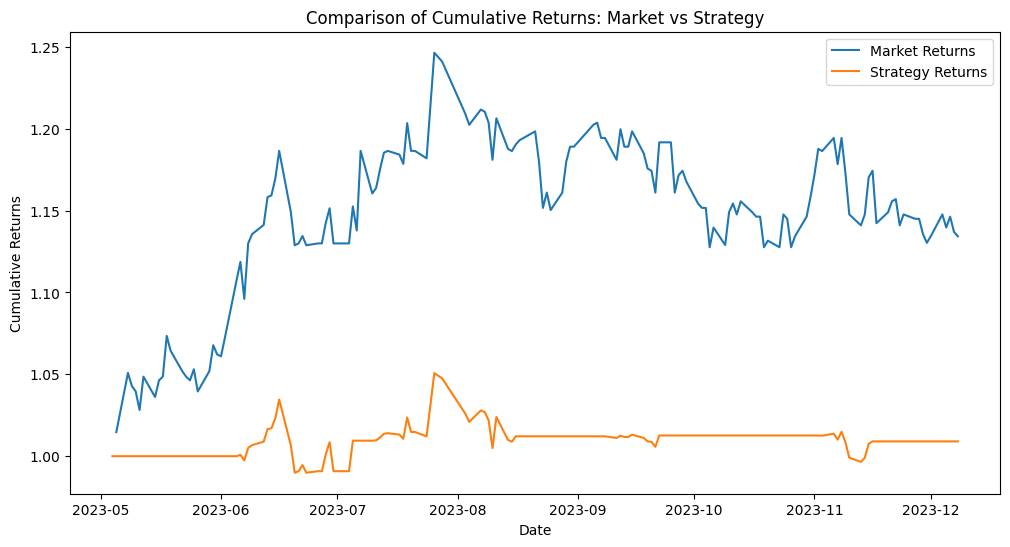

In [ ]:
backtest_mannual = backtest(data_mannual, 100000000, 100)
# backtest.to_csv('data_out_backtest.csv')

# code của AlphaCodium flow

In [ ]:
import pandas as pd
import numpy as np

def calculate_sma(data, window):
    return data.rolling(window).mean().round(6)

def add_signal_columns(data):
    data['BuySignal'] = (data['SMA5'] > data['SMA22']) & (data['Close'] > data['SMA5'])
    data['SellSignal'] = data['SMA5'] < data['SMA22']
    return data

def augment_dataframe(data):
    data['SMA5'] = calculate_sma(data['Close'], 5)
    data['SMA22'] = calculate_sma(data['Close'], 22)
    data = add_signal_columns(data)
    return data

data_ai = augment_dataframe(data_orin)
# def read_input():
#     index, column = input().split('|')
#     data = pd.DataFrame(columns=[index, column])
#     try:
#         while True:
#             row = input().strip().split('|')
#             if len(row) == 2:
#                 row[1] = float(row[1])
#                 data.loc[len(data)] = row
#             else:
#                 break
#     except EOFError:
#         pass
#     return index, column, data

# def print_output(index, column, data):
#     if len(data) == 0:
#         print(f"{index}|{column}|SMA5|SMA22|BuySignal|SellSignal")
#     else:
#         print(f"{index}|{column}|SMA5|SMA22|BuySignal|SellSignal")
#         for _, row in data.iterrows():
#             print(f"{row[index]}|{row[column]}|{row['SMA5']}|{row['SMA22']}|{row['BuySignal']}|{row['SellSignal']}")

# if __name__ == "__main__":
#     index, column, data = read_input()
#     data = augment_dataframe(data)
#     print_output(index, column, data)

In [ ]:
data_ai

,Close,SMA5,SMA22,BuySignal,SellSignal,Position_Buy,Position_Sell,Trade_Action,Capital,Shares_Held,Market_Return,Cumulative_Market_Returns,Strategy_Value,Cumulative_Strategy_Returns
Datetime,,,,,,,,,,,,,,
2023-05-04,74936.492188,NaN,NaN,False,False,NaN,NaN,,1.000000e+08,0,NaN,NaN,1.000000e+08,1.000000
2023-05-05,76037.257812,NaN,NaN,False,False,False,False,,1.000000e+08,0,0.014689,1.014689,1.000000e+08,1.000000
2023-05-08,78746.828125,NaN,NaN,False,False,False,False,,1.000000e+08,0,0.035635,1.050848,1.000000e+08,1.000000
2023-05-09,78154.109375,NaN,NaN,False,False,False,False,,1.000000e+08,0,-0.007527,1.042938,1.000000e+08,1.000000
2023-05-10,77900.085938,77154.954688,NaN,False,False,False,False,,1.000000e+08,0,-0.003250,1.039548,1.000000e+08,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,86000.000000,85320.000000,86645.454545,False,True,False,True,,1.009056e+08,0,0.011765,1.147638,1.009056e+08,1.009056
2023-12-05,85400.000000,85240.000000,86486.363636,False,True,False,True,,1.009056e+08,0,-0.006977,1.139632,1.009056e+08,1.009056
2023-12-06,85900.000000,85400.000000,86322.727273,False,True,False,True,,1.009056e+08,0,0.005855,1.146304,1.009056e+08,1.009056


In [ ]:
import pandas as pd

def initialize_variables(initial_capital):
    capital = initial_capital
    shares_held = 0
    return capital, shares_held

def determine_positions(data):
    data['Position_Buy'] = data['BuySignal'].shift()
    data['Position_Sell'] = data['SellSignal'].shift()
    return data

def create_tracking_table(data):
    tracking_table = data.copy()
    tracking_table['Trade_Action'] = ''
    return tracking_table

def update_trade_action(tracking_table, shares_per_signal):
    buy_condition = (tracking_table['Position_Buy'] == True) & (tracking_table['Capital'].shift() >= tracking_table['Close'] * shares_per_signal)
    sell_condition = (tracking_table['Position_Sell'] == True) & (tracking_table['Shares_Held'].shift() > 0)
    tracking_table.loc[buy_condition, 'Trade_Action'] = 'buy'
    tracking_table.loc[sell_condition, 'Trade_Action'] = 'sell'
    return tracking_table

def update_capital(tracking_table):
    buy_condition = tracking_table['Trade_Action'] == 'buy'
    sell_condition = tracking_table['Trade_Action'] == 'sell'
    tracking_table.loc[buy_condition, 'Capital'] += tracking_table['Close'] * shares_per_signal
    tracking_table.loc[sell_condition, 'Capital'] -= tracking_table['Close'] * shares_per_signal
    return tracking_table

def update_shares_held(tracking_table, shares_per_signal):
    buy_condition = tracking_table['Trade_Action'] == 'buy'
    sell_condition = tracking_table['Trade_Action'] == 'sell'
    tracking_table.loc[buy_condition, 'Shares_Held'] += shares_per_signal
    tracking_table.loc[sell_condition, 'Shares_Held'] -= shares_per_signal
    return tracking_table

def calculate_market_returns(tracking_table):
    tracking_table['Market_Return'] = tracking_table['Close'].pct_change()
    return tracking_table

def calculate_cumulative_market_returns(tracking_table):
    tracking_table['Cumulative_Market_Returns'] = tracking_table['Market_Return'].cumsum()
    return tracking_table

def calculate_strategy_value(tracking_table):
    tracking_table['Strategy_Value'] = tracking_table['Capital'] + (tracking_table['Shares_Held'] * tracking_table['Close'])
    return tracking_table

def calculate_cumulative_strategy_returns(tracking_table, initial_capital):
    tracking_table['Cumulative_Strategy_Returns'] = tracking_table['Strategy_Value'] / initial_capital
    return tracking_table

def round_values(tracking_table):
    tracking_table[['Market_Return', 'Cumulative_Market_Returns', 'Cumulative_Strategy_Returns']] = tracking_table[['Market_Return', 'Cumulative_Market_Returns', 'Cumulative_Strategy_Returns']].round(6)
    return tracking_table

if __name__ == "__main__":
    # index_col, *columns = input().split('|')
    # data = []
    # for line in input().split('\n'):
    #     if line:
    #         data.append(line.split('|'))
    # data = pd.DataFrame(data, columns=[index_col] + columns)
    data = data_orin

    initial_capital = 100000000
    shares_per_signal = 100

    capital, shares_held = initialize_variables(initial_capital)
    data = determine_positions(data)
    tracking_table = create_tracking_table(data)
    tracking_table = update_trade_action(tracking_table, shares_per_signal)
    tracking_table = update_capital(tracking_table)
    tracking_table = update_shares_held(tracking_table, shares_per_signal)
    tracking_table = calculate_market_returns(tracking_table)
    tracking_table = calculate_cumulative_market_returns(tracking_table)
    tracking_table = calculate_strategy_value(tracking_table)
    tracking_table = calculate_cumulative_strategy_returns(tracking_table, initial_capital)
    tracking_table = round_values(tracking_table)

    print(tracking_table.to_string(index=False))

       Close         SMA5        SMA22  BuySignal  SellSignal      Capital  Shares_Held Position_Buy Position_Sell Trade_Action  Market_Return  Cumulative_Market_Returns  Strategy_Value  Cumulative_Strategy_Returns
74936.492188          NaN          NaN      False       False 1.000000e+08            0          NaN           NaN                         NaN                        NaN    1.000000e+08                     1.000000
76037.257812          NaN          NaN      False       False 1.000000e+08            0        False         False                    0.014689                   0.014689    1.000000e+08                     1.000000
78746.828125          NaN          NaN      False       False 1.000000e+08            0        False         False                    0.035635                   0.050324    1.000000e+08                     1.000000
78154.109375          NaN          NaN      False       False 1.000000e+08            0        False         False                   -0.0075

In [ ]:
backtest_mannual

,Close,SMA5,SMA22,BuySignal,SellSignal,Position_Buy,Position_Sell,Trade_Action,Capital,Shares_Held,Market_Return,Cumulative_Market_Returns,Strategy_Value,Cumulative_Strategy_Returns
Datetime,,,,,,,,,,,,,,
2023-05-04,74936.492188,NaN,NaN,False,False,NaN,NaN,,1.000000e+08,0,NaN,NaN,1.000000e+08,1.000000
2023-05-05,76037.257812,NaN,NaN,False,False,False,False,,1.000000e+08,0,0.014689,1.014689,1.000000e+08,1.000000
2023-05-08,78746.828125,NaN,NaN,False,False,False,False,,1.000000e+08,0,0.035635,1.050848,1.000000e+08,1.000000
2023-05-09,78154.109375,NaN,NaN,False,False,False,False,,1.000000e+08,0,-0.007527,1.042938,1.000000e+08,1.000000
2023-05-10,77900.085938,77154.954687,NaN,False,False,False,False,,1.000000e+08,0,-0.003250,1.039548,1.000000e+08,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,86000.000000,85320.000000,86645.454545,False,True,False,True,,1.009056e+08,0,0.011765,1.147638,1.009056e+08,1.009056
2023-12-05,85400.000000,85240.000000,86486.363636,False,True,False,True,,1.009056e+08,0,-0.006977,1.139632,1.009056e+08,1.009056
2023-12-06,85900.000000,85400.000000,86322.727273,False,True,False,True,,1.009056e+08,0,0.005855,1.146304,1.009056e+08,1.009056


**So sánh:**
- Code của problem 1 (trading strategy) do AI hoạt động hiệu quả, tuy trong quá trình tạo, không pass 1 public test, lí do được kiểm tra lại là do, làm tròn số thập phân khác nhau khiến kết quả khác nhau.

- code của problem 2 (back test) không hoạt động hiệu quả, vẫn có bug, cần phải cân nhắc đủ các trường hợp (edge case) để mô tả đầy đủ, chính xác và phù hợp; đồng thời, cung cấp thêm các trường hợp public test có thể làm rõ trường hợp này, giúp LLM phát hiện bug và chỉnh code.